In [1]:
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv("train.csv")

In [3]:
data

,text,aspect,label
0,can you check whether its cancelled completely?,cancelled,1
1,cannot rely on both milk delivery and grocery ...,Milk,0
2,"I get no notification, however the app is real...",notification,0
3,"Love this app, but would love it even more if ...",view,1
4,it does not let me load a clip on the scene,load,0
...,...,...,...
3995,every time i try to edit a page or create a li...,tools,0
3996,unable to load money using wallets (phonepe/ol...,Unable to load money using wallets,0
3997,"hi, i m doing for the first time ever and i no...",usage,0
3998,delivery is delayed or cancelled every time i ...,Delivery,0


<AxesSubplot:xlabel='label', ylabel='count'>

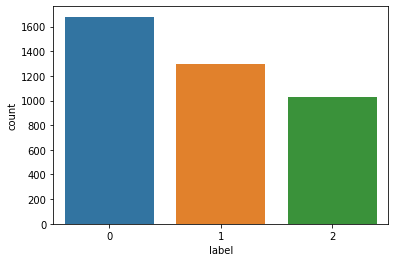

In [4]:
sns.countplot(x='label', data=data)

In [5]:
ps = PorterStemmer()
def clean_text(text): 
    ptext = re.sub('http[s]?://\S+', '', text)
    ptext = re.sub('[^0-9a-zA-Z]', ' ', ptext)
    ptext = ptext.lower()
    
    ptext = re.sub(r'(\s)emoticonX\w+', '', ptext)
    
    ptext = ptext.split()
    ptext = [ps.stem(word) for word in ptext if not word in stopwords.words('english')]
    
    ptext = ' '.join(ptext)
    
    return ptext
data['text'] = data['text'].apply(clean_text)
data['aspect'] = data['aspect'].apply(clean_text)

In [6]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['text'])

In [7]:
tokenized_text = tokenizer.texts_to_sequences(data['text'])
tokenized_aspect = tokenizer.texts_to_sequences(data['aspect'])

In [22]:
embedded_text=pad_sequences(tokenized_text,padding='pre',maxlen=120)
print(embedded_text)

embedded_aspect=pad_sequences(tokenized_aspect,padding='pre',maxlen=8)
print(embedded_aspect)

[[   0    0    0 ...  372   47  228]
 [   0    0    0 ...    3  396   45]
 [   0    0    0 ...    1   53  330]
 ...
 [   0    0    0 ... 1791  441    1]
 [   0    0    0 ...    5   70  248]
 [   0    0    0 ...   29   13  484]]
[[   0    0    0 ...    0    0   47]
 [   0    0    0 ...    0    0   22]
 [   0    0    0 ...    0    0  218]
 ...
 [   0    0    0 ...    0    0 1791]
 [   0    0    0 ...    0    0    3]
 [   0    0    0 ...    0   29   13]]


In [23]:
len(embedded_text),len(embedded_aspect),data['label'].shape

(4000, 4000, (4000,))

In [24]:
X1=np.array(embedded_text)
X2=np.array(embedded_aspect)
y=np.array(data['label'])

In [25]:
input_1 = Input(shape=(120,))

input_2 = Input(shape=(8,))

In [26]:
embedding_layer_1 = Embedding(5000, 120)(input_1)
LSTM_Layer_1 = LSTM(128)(embedding_layer_1)

In [27]:
embedding_layer_2 = Embedding(5000, 8)(input_2)
LSTM_Layer_2 = LSTM(32)(embedding_layer_2)

In [28]:
concat_layer = Concatenate()([LSTM_Layer_1, LSTM_Layer_2])
dense_layer_1 = Dense(10, activation='relu')(concat_layer)
output = Dense(3, activation='softmax')(dense_layer_1)
model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

In [29]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 120, 120)     600000      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 8, 8)         40000       input_4[0][0]                    
____________________________________________________________________________________________

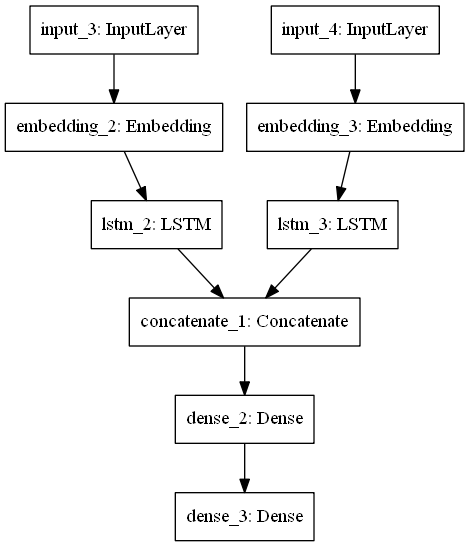

In [30]:
tf.keras.utils.plot_model(model)

In [31]:
X1.shape

(4000, 120)

In [32]:
X1_train, X1_test,X2_train, X2_test, y_train, y_test = train_test_split(X1,X2, y, test_size=0.2, random_state=42)
print('Train text data len:'+str(len(X1_train)))
print('Train aspect data len:'+str(len(X2_train)))
print('Class distribution\n'+str((pd.Series(y_train)).value_counts()))
print()
print('Test text data len:'+str(len(X1_test)))
print('Test aspect data len:'+str(len(X2_test)))
print('Class distribution\n'+str((pd.Series(y_test)).value_counts()))

Train text data len:3200
Train aspect data len:3200
Class distribution
0    1328
1    1056
2     816
dtype: int64

Test text data len:800
Test aspect data len:800
Class distribution
0    352
1    238
2    210
dtype: int64


In [33]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [34]:
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
20/20 [==============================] - 14s 478ms/step - loss: 1.0808 - acc: 0.4094 - val_loss: 1.0754 - val_acc: 0.3953
Epoch 2/5
20/20 [==============================] - 8s 405ms/step - loss: 1.0243 - acc: 0.4660 - val_loss: 0.9916 - val_acc: 0.5562
Epoch 3/5
20/20 [==============================] - 8s 400ms/step - loss: 0.7951 - acc: 0.6844 - val_loss: 0.8715 - val_acc: 0.6375
Epoch 4/5
20/20 [==============================] - 8s 398ms/step - loss: 0.5826 - acc: 0.7852 - val_loss: 0.8443 - val_acc: 0.6328
Epoch 5/5
20/20 [==============================] - 8s 410ms/step - loss: 0.4374 - acc: 0.8398 - val_loss: 0.9298 - val_acc: 0.6484


In [45]:
loss,accuracy=model.evaluate([X1_test,X2_test],y_test)

print('Accuracy: {}'.format(round(accuracy,2)))
print('Loss: {}'.format(round(loss,2)))

25/25 [==============================] - 2s 64ms/step - loss: 0.8919 - acc: 0.6300
Accuracy: 0.63
Loss: 0.89


In [41]:
model.predict([X1_test,X2_test])

array([[0.4893831 , 0.49021277, 0.02040413],
       [0.9090809 , 0.01252599, 0.07839309],
       [0.09222812, 0.01235159, 0.8954203 ],
       ...,
       [0.19576305, 0.5069262 , 0.29731083],
       [0.30454358, 0.07033014, 0.62512624],
       [0.8508949 , 0.03866032, 0.1104448 ]], dtype=float32)

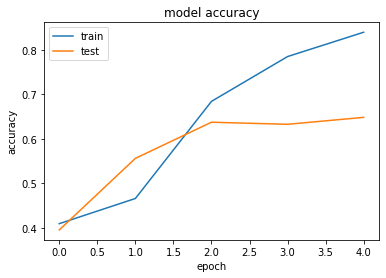

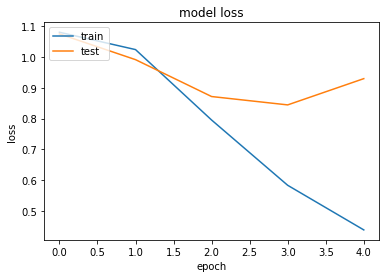

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()